In [201]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns

In [122]:
# reading tags
tags_raw: pd.DataFrame = pd.read_csv('tags.csv', sep='\t')
tags_agg: pd.DataFrame = tags_raw.groupby('Id').agg(lambda x: x.tolist())

# reading questions
questions_raw: pd.DataFrame = pd.read_csv('Questions.csv', sep=',', encoding='utf-16').drop(['CreationDate','ClosedDate'], axis=1).sort_values(by='Score')

In [285]:
# filter input data and return question frame and tags that are in the questions
def filter_data(score_limit: int=0, comment_limit: int=0)-> (pd.DataFrame, pd.Series):
    # filter questions base on score and comment's count
    questions_filtered: pd.DataFrame = questions_raw[questions_raw['Score'] > score_limit]
    questions_filtered = questions_filtered[questions_filtered['CommentCount'] > comment_limit]
    # add tags list to the questions
    questions_result: pd.DataFrame = questions_filtered.merge(tags_agg, left_on='Id', right_on='Id', how='inner')
    # calculate list of unique tags included in the questions
    tags_result: pd.Series = questions_result.Tags.explode(ignore_index=True).drop_duplicates()
    return questions_result, tags_result

# return index of questions including all the input tags
def index_all_tags(tag_list)-> pd.Series:
    return ~questions.Tags.apply(lambda y: any(set(tag_list) - set(y)) )

# what is the probability of tag2 being in the same set of tag1
def calculate_tag_confidence(tag1: str, tag2: str)-> float:
    tags_join = index_all_tags([tag1, tag2]).value_counts()
    # zero count if no True is present otherwise count is equal to number of Trues.
    join_count = 0 if len(tags_join) < 2 else tags_join[1]
    tags_tag1 = index_all_tags([tag1]).value_counts()
    tag1_count = 0 if len(tags_tag1) < 2 else tags_tag1[1]
    return join_count / tag1_count

# set confidence for column of input tag.
def set_confidence(df: pd.DataFrame, tag: str):
    # calculate for tags that have minimum one intersect with input tag
    for i in questions[index_all_tags([tag])].Tags.explode(ignore_index=True).drop_duplicates():
        df[tag][i] = calculate_tag_confidence(tag, i)

# calculate distance between two tags
def calculate_distance(tag1: str, tag2: str) -> float:
    return 1 - calculate_tag_confidence(tag1, tag2)

In [284]:
# getting base questions and tags
questions, tags = filter_data(score_limit=10,comment_limit=0)

In [199]:
# matrix oc similarities between every pair of tags. initial value is NaN.
similarity_table: pd.DataFrame = pd.crosstab(tags,tags, values=[0 for i in range(0,len(tags))], aggfunc=lambda x: 0)

# set confidence for each pair of tags.
for each in tqdm(similarity_table.index):
    set_confidence(similarity_table,each)

100%|██████████| 3647/3647 [39:30<00:00,  1.54it/s]  


In [200]:
similarity_table

Tags,.class-file,.net,2-3-4-tree,2d,2d-games,32-bit,32bit-64bit,3d,64bit,7zip,...,zero-pad,zeroconf,zeromq,zimbra,zip,zipinputstream,zipoutputstream,zookeeper,zoom,zxing
Tags,,,,,,,,,,,,,,,,,,,,,
.class-file,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
.net,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2-3-4-tree,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2d,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2d-games,NaN,NaN,NaN,0.2,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zipinputstream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN
zipoutputstream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.5,1.0,NaN,NaN,NaN
zookeeper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


<AxesSubplot:xlabel='Id', ylabel='Score'>

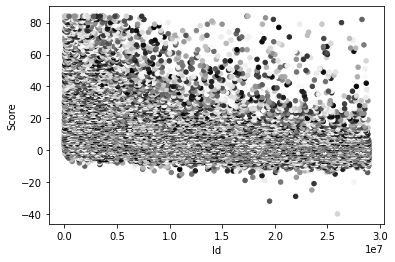

In [135]:
# show Score distributions over Id from 0 to N-1000's question.
# questions are sorted
colors = np.random.rand(len(questions_raw)-1000)
questions_raw[0:-1000].plot.scatter(x='Id',y='Score',c=colors)

<AxesSubplot:xlabel='Id', ylabel='Score'>

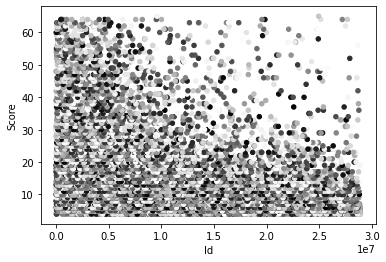

In [144]:
# same as previous one but on filtered questions
colors = np.random.rand(len(questions)-1000)
questions[0:-1000].plot.scatter(x='Id',y='Score',c=colors)

<AxesSubplot:xlabel='Tags', ylabel='Tags'>

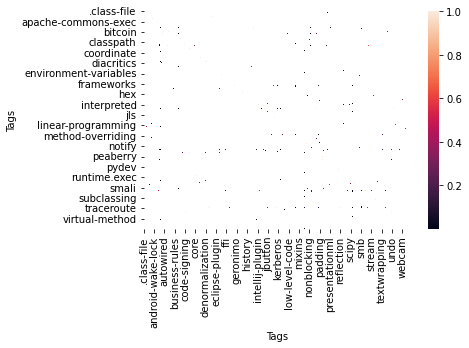

In [202]:
# heatmap of similarity table
sns.heatmap(similarity_table)

In [213]:
# calculate top 10 similar tags for intellij-idea
similarity_table.nlargest(10,columns='intellij-idea')['intellij-idea']

Tags
intellij-idea     1.000000
android           0.134831
eclipse           0.134831
ide               0.112360
android-studio    0.078652
junit             0.056180
osx               0.044944
gradle            0.033708
refactoring       0.033708
annotations       0.022472
Name: intellij-idea, dtype: float64

In [214]:
# calculate top 10 similar tags for jax-rs
similarity_table.nlargest(10,columns='jax-rs')['jax-rs']

Tags
jax-rs          1.00000
jersey          0.37500
rest            0.37500
java-ee         0.12500
resteasy        0.12500
junit           0.09375
jax-ws          0.06250
jaxb            0.06250
servlets        0.06250
unit-testing    0.06250
Name: jax-rs, dtype: float64

In [215]:
# calculate top 10 similar tags for user-interface
similarity_table.nlargest(10,columns='user-interface')['user-interface']

Tags
user-interface    1.000000
swing             0.587302
awt               0.079365
swt               0.079365
android           0.063492
jframe            0.063492
jbutton           0.047619
windows           0.047619
c#                0.031746
c++               0.031746
Name: user-interface, dtype: float64

In [286]:
# calculate distance

print(f'regex static -> {calculate_distance("regex","static")}')
print(f'session spring -> {calculate_distance("session","spring")}')
print(f'nullpointerexception dependency-injection -> {calculate_distance("nullpointerexception","dependency-injection")}')

regex static -> 0.9997425334706488
session spring -> 0.8764302059496567
nullpointerexception dependency-injection -> 0.9981185324553151


In [267]:
#find all top tags
# initial list
tops: pd.DataFrame = pd.DataFrame({'tags': [], 'similarity': []},columns=['tags','similarity'])

for tag in tqdm(similarity_table.index):
    # get top 2 tags in each column
    each = similarity_table.sort_values(by=tag, ascending=False)[tag].head(2)
    # add tags and similarity's probability to list
    tops =tops.append(pd.DataFrame({'tags': [each.index.array], 'similarity': [each.values[1]]}), ignore_index=True)

tops

100%|██████████| 3647/3647 [05:08<00:00, 11.83it/s]


,tags,similarity
0,"[.class-file, bytecode]",0.500000
1,"[.net, c#]",0.362500
2,"[2-3-4-tree, algorithm]",1.000000
3,"[2d, sprite]",0.400000
4,"[2d, 2d-games]",1.000000
...,...,...
3642,"[zipinputstream, android]",0.500000
3643,"[zipinputstream, zipoutputstream]",1.000000
3644,"[zookeeper, configuration]",0.250000
3645,"[zoom, android]",0.500000


In [283]:
# sort tops by similarity and return top 10
tops.sort_values(by='similarity',ascending=False).head(10)

,tags,similarity
1119,"[failover, failovercluster]",1.0
1435,"[http-chunked, httpurlconnection]",1.0
2759,"[rounded-corners, swing]",1.0
2761,"[bigdecimal, numerical-analysis]",1.0
2763,"[rrd, rrdtool]",1.0
1448,"[httpsession, servlets]",1.0
1446,"[http, httpresponse]",1.0
2764,"[rrd, rrdtool]",1.0
2765,"[communication, industrial]",1.0
1443,"[http, http-status-codes]",1.0
